# **Mount Google Drive, import modules, and set paths.**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import os
import time
import sys
import argparse
import random
import math
import itertools

from matplotlib import pyplot as plt
import cv2
import numpy as np
from skimage import segmentation
from skimage.filters import threshold_multiotsu
from astropy.convolution import convolve, Gaussian2DKernel, Tophat2DKernel
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from keras.preprocessing.image import array_to_img, img_to_array, load_img
import torch
import torch.nn as nn
import tensorflow as tf

import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.nn.init
import random
from tqdm import tqdm  

import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact
import matplotlib.image as mpimg
from IPython.display import clear_output
from ipywidgets import Layout

from skimage.util import img_as_ubyte
from skimage.filters.rank import entropy
from skimage.morphology import disk
from sklearn.preprocessing import StandardScaler
from scipy.special import softmax
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [ ]:
# Add the path where the data are uploaded.
path_prefix = '/content/gdrive/My Drive/'
customized_path_to_project_path = 'Unsupervised_Learning/'
sys_path = path_prefix + customized_path_to_project_path
sys.path.append(sys_path)
Noise_analysis_path = sys_path+'Figures/SyntheticData/'

img_path = sys_path + 'Image_Data/'
npy_path = img_path + 'Seg_Matrix/'
npy_files = os.listdir(img_path + 'Seg_Matrix/')
seg_result_qualified_path = img_path + 'Seg_Matrix_four/'
seg_final_path = img_path + 'Seg_matrix_final/'
image_num = 1700

# **Sub-functions**

1. Raw data visualization

In [ ]:
# Only .jpg file can be read...
style = {'description_width': 'initial'}

def pre_binary_slice_visualize(image_num):
  def my_function(slice_num):
   
    imgbox_1 = widgets.Image(format='jpg', height=600, width=600)
    i = slice_num

    image_pre_path = img_path+'Cropped_Filtered/cycle-2-cropped-filtered'+str(i-1).zfill(4)+'.tif'
    canvas_1 = cv2.imread(image_pre_path, cv2.IMREAD_GRAYSCALE)
    a,b = canvas_1.shape
    imgbox_1.value = cv2.imencode('.jpg', canvas_1)[1].tobytes()
    
    slice_num = widgets.IntText(
        value=1,
        description='Slice Number:',
        disabled=False,
        style = style
        )
    
    image_length = widgets.IntText(
        # Depends on the outputs
        value=a,
        description='Length Voxel Number:',
        disabled=False,
        style = style
        )
    
    image_width = widgets.IntText(
        # Depends on the outputs
        value=b,
        description='Width Voxel Number:',
        disabled=False,
        style = style
        )
    
    slice_num.value = i
    sidebyside = widgets.VBox([widgets.HBox([imgbox_1]), widgets.VBox([slice_num, image_length, image_width])])
    display(sidebyside)
    
  interact(my_function, slice_num=list(range(1,image_num)))

2. CNN module design

In [ ]:
class Args(object):
  scribble = False # 
  mod_dim1 = 128 # number of channels
  mod_dim2 = 128 # number of channels
  mod_dim3 = 128 # number of channels
  mod_dim4 = 32 # number of channels

  mod_dim_output = mod_dim4
  maxIter = 5000 # number of maximum iterations
  minLabels = 8 # minimum number of labels
  visualize = 0 # visualization flag
  lr = 0.05 # learning rate
  nConv = 4 # number of convolutional layers

  stepsize_sim = 1 # step size for similarity loss
  stepsize_con = 2 # step size for continuity loss
  stepsize_scr = 0.5 # step size for scribble loss
  gpu_id = 0 # GPU ID

In [ ]:
class MyNet_1(nn.Module):
  def __init__(self, inp_dim, mod_dim1, mod_dim2, mod_dim3, mod_dim4):
    super(MyNet_1, self).__init__()

    self.seq = nn.Sequential(
        # 1 32
        nn.Conv2d(inp_dim, mod_dim1, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(mod_dim1),
        nn.ReLU(inplace=True),

        # 32 32
        nn.Conv2d(mod_dim1, mod_dim4, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(mod_dim4),
    )

  def forward(self, x):
    return self.seq(x)

In [ ]:
class MyNet_2(nn.Module):
  def __init__(self, inp_dim, mod_dim1, mod_dim2, mod_dim3, mod_dim4):
    super(MyNet_2, self).__init__()

    self.seq = nn.Sequential(
        # 1 128
        nn.Conv2d(inp_dim, mod_dim1, kernel_size=3, stride=1, padding='same'),
        nn.BatchNorm2d(mod_dim1),
        nn.ReLU(inplace=True),

        # 128 64
        nn.Conv2d(mod_dim1, mod_dim2, kernel_size=3, stride=1, padding='same'),
        nn.BatchNorm2d(mod_dim2),
        nn.ReLU(inplace=True),

        # 64 32
        nn.Conv2d(mod_dim2, mod_dim4, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(mod_dim4),
    )

  def forward(self, x):
    return self.seq(x)

In [ ]:
class MyNet_3(nn.Module):
  def __init__(self, inp_dim, mod_dim1, mod_dim2, mod_dim3, mod_dim4):
    super(MyNet_3, self).__init__()

    self.seq = nn.Sequential(
        # 1 128
        nn.Conv2d(inp_dim, mod_dim1, kernel_size=3, stride=1, padding='same'),
        nn.BatchNorm2d(mod_dim1),
        nn.ReLU(inplace=True),

        # 128 128
        nn.Conv2d(mod_dim1, mod_dim2, kernel_size=3, stride=1, padding='same'),
        nn.BatchNorm2d(mod_dim2),
        nn.ReLU(inplace=True),

        # 128 128
        nn.Conv2d(mod_dim2, mod_dim3, kernel_size=3, stride=1, padding='same'),
        nn.BatchNorm2d(mod_dim3),
        nn.ReLU(inplace=True),

        # 128 32
        nn.Conv2d(mod_dim3, mod_dim4, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(mod_dim4),
    )

  def forward(self, x):
    return self.seq(x)

3. Multi-image processing

In [ ]:
def seg_process(img_num):
  img_num = img_num
  file_name = img_path+'Cropped_Filtered/cycle-2-cropped-filtered' + str(img_num).zfill(4) + '.tif'
  im = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
  para_matrix = np.zeros((50, 8))
  filter_num = 0

  for iter_num in tqdm(range(50)):
    run(file_name)

    im_target_rgb = cv2.imread(sys_path+'output.tif', cv2.IMREAD_GRAYSCALE)
    target_label = np.unique(im_target_rgb)
    im_label_mean = np.zeros(len(target_label))

    for i in range(len(target_label)):
      a = (im_target_rgb == target_label[i])
      b = a * im
      c = np.nonzero(b)
      non_num = len(c[0])
      if non_num == 0:
        pass
      else: 
        im_label_mean[i] = int(np.sum(b[:])/non_num)
        im_target_rgb[im_target_rgb == target_label[i]] = im_label_mean[i]

    cv2.imwrite(sys_path + "output_mean.tif", im_target_rgb)
    im_label_mean.sort()

    if len(im_label_mean) > 8:
      para_matrix[iter_num, :] = im_label_mean[0:8]
    else:
      im_label_supp = np.zeros(8-len(im_label_mean))
      im_label_mean = np.concatenate((im_label_mean, im_label_supp))
      para_matrix[iter_num, :] = im_label_mean

    co2_index = 1
    solid_index = 1

    if im_label_mean[0] > 50:
      co2_index = 0

    if im_label_mean[2] < 135:
      solid_index = 0

    filter_index = co2_index * solid_index

    if filter_index:
      print('Filtering condition satisfied:')
      print(iter_num)
      print(im_label_mean)
      im_target_rgb = im_target_rgb.reshape(1300,1300,1)

      im_target_rgb[im_target_rgb == im_label_mean[0]] = 0
      im_target_rgb[im_target_rgb > (im_label_mean[2]-1)] = 255
      im_target_rgb[im_target_rgb == im_label_mean[1]] = 127

      if filter_num == 0:
        seg_result = im_target_rgb
      else:
        seg_result = np.dstack((seg_result, im_target_rgb))

      filter_num += 1

  cv2.imwrite(sys_path + "output_three.tif", im_target_rgb)
  np.save(img_path + str(img_num).zfill(4) + '_' + str(filter_num) + '.npy', seg_result)

4. Segmentation result visualization

In [ ]:
def seg_visualize(image_num):
  def my_function(slice_num):

    file_name = img_path+'Cropped_Filtered/cycle-2-cropped-filtered' + img_num + '.tif'

    imgbox_1 = widgets.Image(format='jpg', height=800, width=800)
    imgbox_2 = widgets.Image(format='jpg', height=800, width=800)
    i = slice_num
    img_data = seg_result[:,:,i-1]
    img_data = img_data.reshape(1300,1300,1)
    #cv2.imwrite(sys_path + "output2.tif", img_data)

    brine_num = np.sum(img_data == 127)
    brine_frac = brine_num/(1300*1300)
    co2_num = np.sum(img_data == 0)
    co2_frac = co2_num/(1300*1300)

    canvas_1 = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
    #canvas_2 = cv2.imread(sys_path + "output2.tif", cv2.IMREAD_GRAYSCALE)
    a,b = canvas_1.shape

    imgbox_1.value = cv2.imencode('.jpg', canvas_1)[1].tobytes()
    imgbox_2.value = cv2.imencode('.jpg', img_data)[1].tobytes()
    
    slice_num = widgets.IntText(
        value=1,
        description='Slice Number:',
        disabled=False,
        style = style
        )
    
    CO2_frac = widgets.FloatText(
        # Depends on the outputs
        description='CO2 Fraction',
        disabled=False,
        style = style
        )
    
    Brine_frac = widgets.FloatText(
        # Depends on the outputs
        description='Brine Fraction:',
        disabled=False,
        style = style
        )
    
    button = widgets.Button(description="Save Image")

    def save():
      print(i)
      cv2.imwrite(seg_final_path + img_num + '.png', img_data)

    def on_button_clicked(b):
      save()

    button.on_click(on_button_clicked)
    
    slice_num.value = i
    CO2_frac.value = co2_frac
    Brine_frac.value = brine_frac
    sidebyside = widgets.VBox([widgets.HBox([imgbox_1,imgbox_2]), widgets.VBox([slice_num, CO2_frac, Brine_frac, button])])
    display(sidebyside)
    
  interact(my_function, slice_num=list(range(1,image_num+1)))

In [ ]:
def unsup_view(seg_matrix_name):
  
  seg_result = np.load(img_path + 'Seg_Matrix/' + seg_matrix_name)
  
  seg_matrix_file = seg_matrix_name.split('_')
  img_num = seg_matrix_file[0]
  filter_num = int(seg_matrix_file[1].split('.')[0])
  
  col_num = 4
  row_num = math.ceil(filter_num/col_num)
  fig = plt.figure(figsize=(col_num*15,row_num*15))
  
  for i in range(row_num):
    for j in range(col_num):
      img_index = i*4+j+1
      
      if img_index > filter_num:
        break

      im = seg_result[:,:,img_index-1]

      co2_num = np.sum((im == 0))
      co2_frac = co2_num/(1300*1300)
      brine_num = np.sum(im == 127)
      brine_frac = brine_num/(1300*1300)

      plt.subplot(row_num,col_num,img_index)
      plt.imshow(array_to_img(im.reshape(1300,1300,1)),cmap='gray')
      plt.gca().set_title(str(img_index)+'/'+str(co2_frac)+'/'+str(brine_frac))

In [ ]:
def first_selection(filter_num,seg_result):
  
  brine_frac_list = []
  brine_frac_unqua_num = 0

  for seg_res_index in range(filter_num):
    im = seg_result[:,:,seg_res_index]

    brine_num = np.sum(im == 127)
    brine_frac = brine_num/(1300*1300)
    brine_frac_list.append(brine_frac)
    if brine_frac < 0.08:
      brine_frac_unqua_num += 1

  brine_frac_sort = np.argsort(brine_frac_list)
  brine_little_four = brine_frac_sort[brine_frac_unqua_num:brine_frac_unqua_num+4]
  brine_little_four_len = len(brine_little_four)
  seg_result_qualified = np.zeros((1300,1300,brine_little_four_len))

  for except_index in range(brine_little_four_len):
    seg_result_qualified[:,:,except_index] = seg_result[:,:,brine_little_four[except_index]]

  return seg_result_qualified, brine_little_four_len

In [ ]:
def filter_num_check(total_image_num):

  less_than_standard = []

  for index in range(total_image_num):
    index_prefix = str(index).zfill(4)
    seg_matrix_list = [f for f in os.listdir(npy_path) if f.startswith(index_prefix)]
    seg_matrix_list_len = len(seg_matrix_list)

    if seg_matrix_list_len == 1:
      seg_matrix_name = seg_matrix_list[0]
    else:
      print('Error! There are %s files detected!' % seg_matrix_list_len)
      print(index)
  
    seg_matrix_file = seg_matrix_name.split('_')
    filter_num = int(seg_matrix_file[1].split('.')[0])

    if filter_num < 4:
      less_than_standard.append(index)

  return less_than_standard

5. Evaluation metrics

In [ ]:
def model_evaluation(label_true_flatten,label_pred_flatten):
  print('\nClassification Report\n')
  print(classification_report(label_true_flatten, label_pred_flatten, target_names=['scCO2', 'brine', 'rock'],digits=4))

def metrics_np(y_true, y_pred, metric_name,
    metric_type='standard', drop_last = True, mean_per_class=False, verbose=False):
    """
    Compute mean metrics of two segmentation masks, via numpy.

    IoU(A,B) = |A & B| / (| A U B|)
    Dice(A,B) = 2*|A & B| / (|A| + |B|)

    Args:
        y_true: true masks, one-hot encoded.
        y_pred: predicted masks, either softmax outputs, or one-hot encoded.
        metric_name: metric to be computed, either 'iou' or 'dice'.
        metric_type: one of 'standard' (default), 'soft', 'naive'.
          In the standard version, y_pred is one-hot encoded and the mean
          is taken only over classes that are present (in y_true or y_pred).
          The 'soft' version of the metrics are computed without one-hot
          encoding y_pred.
          The 'naive' version return mean metrics where absent classes contribute
          to the class mean as 1.0 (instead of being dropped from the mean).
        drop_last = True: boolean flag to drop last class (usually reserved
          for background class in semantic segmentation)
        mean_per_class = False: return mean along batch axis for each class.
        verbose = False: print intermediate results such as intersection, union
          (as number of pixels).
    Returns:
        IoU/Dice of y_true and y_pred, as a float, unless mean_per_class == True
          in which case it returns the per-class metric, averaged over the batch.

    Inputs are B*W*H*N tensors, with
        B = batch size,
        W = width,
        H = height,
        N = number of classes
    """

    assert y_true.shape == y_pred.shape, 'Input masks should be same shape, instead are {}, {}'.format(y_true.shape, y_pred.shape)
    assert len(y_pred.shape) == 4, 'Inputs should be B*W*H*N tensors, instead have shape {}'.format(y_pred.shape)

    flag_soft = (metric_type == 'soft')
    flag_naive_mean = (metric_type == 'naive')

    num_classes = y_pred.shape[-1]
    # if only 1 class, there is no background class and it should never be dropped
    drop_last = drop_last and num_classes>1

    if not flag_soft:
        if num_classes>1:
            # get one-hot encoded masks from y_pred (true masks should already be in correct format, do it anyway)
            y_pred = np.array([ np.argmax(y_pred, axis=-1)==i for i in range(num_classes) ]).transpose(1,2,3,0)
            y_true = np.array([ np.argmax(y_true, axis=-1)==i for i in range(num_classes) ]).transpose(1,2,3,0)
        else:
            y_pred = (y_pred > 0).astype(int)
            y_true = (y_true > 0).astype(int)

    # intersection and union shapes are batch_size * n_classes (values = area in pixels)
    axes = (1,2) # W,H axes of each image
    intersection = np.sum(np.abs(y_pred * y_true), axis=axes) # or, np.logical_and(y_pred, y_true) for one-hot
    mask_sum = np.sum(np.abs(y_true), axis=axes) + np.sum(np.abs(y_pred), axis=axes)
    union = mask_sum  - intersection # or, np.logical_or(y_pred, y_true) for one-hot

    if verbose:
        print('intersection (pred*true), intersection (pred&true), union (pred+true-inters), union (pred|true)')
        print(intersection, np.sum(np.logical_and(y_pred, y_true), axis=axes), union, np.sum(np.logical_or(y_pred, y_true), axis=axes))

    smooth = .001
    iou = (intersection + smooth) / (union + smooth)
    dice = 2*(intersection + smooth)/(mask_sum + smooth)

    metric = {'iou': iou, 'dice': dice}[metric_name]

    # define mask to be 0 when no pixels are present in either y_true or y_pred, 1 otherwise
    mask =  np.not_equal(union, 0).astype(int)
    # mask = 1 - np.equal(union, 0).astype(int) # True = 1

    if drop_last:
        metric = metric[:,:-1]
        mask = mask[:,:-1]

    # return mean metrics: remaining axes are (batch, classes)
    # if mean_per_class, average over batch axis only
    # if flag_naive_mean, average over absent classes too
    if mean_per_class:
        if flag_naive_mean:
            return np.mean(metric, axis=0)
        else:
            # mean only over non-absent classes in batch (still return 1 if class absent for whole batch)
            return (np.sum(metric * mask, axis=0) + smooth)/(np.sum(mask, axis=0) + smooth)
    else:
        if flag_naive_mean:
            return np.mean(metric)
        else:
            # mean only over non-absent classes
            class_count = np.sum(mask, axis=0)
            return np.mean(np.sum(metric * mask, axis=0)[class_count!=0]/(class_count[class_count!=0]))

def mean_iou_np(y_true, y_pred, **kwargs):
    """
    Compute mean Intersection over Union of two segmentation masks, via numpy.

    Calls metrics_np(y_true, y_pred, metric_name='iou'), see there for allowed kwargs.
    """
    return metrics_np(y_true, y_pred, metric_name='iou', **kwargs)

def mean_dice_np(y_true, y_pred, **kwargs):
    """
    Compute mean Dice coefficient of two segmentation masks, via numpy.

    Calls metrics_np(y_true, y_pred, metric_name='dice'), see there for allowed kwargs.
    """
    return metrics_np(y_true, y_pred, metric_name='dice', **kwargs)

In [ ]:
def sp_noise(image,prob):
  '''
  Add salt and pepper noise to image
  prob: Probability of the noise
  '''
  output = np.zeros(image.shape,np.uint8)
  thres = 1 - prob 
  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      rdn = random.random()
      if rdn < prob:
        output[i][j] = 0
      elif rdn > thres:
        output[i][j] = 255
      else:
        output[i][j] = image[i][j]
  
  return output

# **Raw data visualization**

In [ ]:
pre_binary_slice_button = widgets.Button(description="CT Slice", layout=Layout(width='50%', height='40px'))
output = widgets.Output()

# image_num depends on the outputs
def pre_binary_slice_button_clicked(b, image_num=1701): 
# def pre_binary_slice_button_clicked(b, image_num=20):
  with output:
    clear_output(wait=True)
    pre_binary_slice_visualize(image_num)

pre_binary_slice_button.on_click(pre_binary_slice_button_clicked)
button = widgets.HBox([pre_binary_slice_button])
display(button, output)

Output()

# **Run main codes**

1. Implement model

Model_n with n set of convolution+ReLU+BN layers

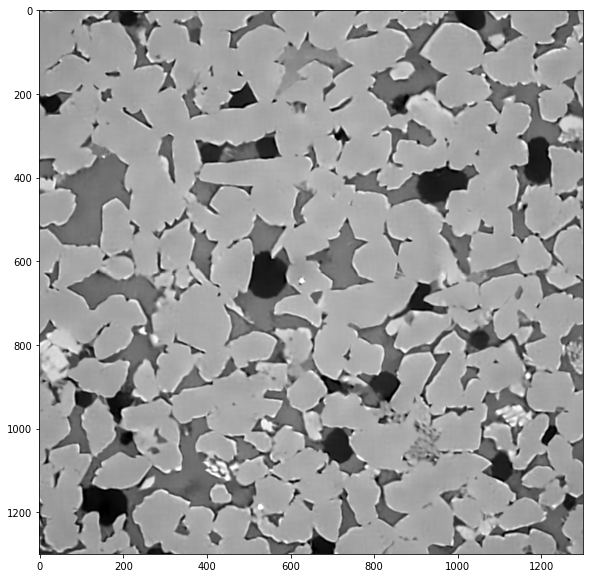

In [ ]:
img_index = 420
file_name = img_path + 'Cropped_Filtered/cycle-2-cropped-filtered'+str(img_index).zfill(4)+'.tif'
#file_name = Noise_analysis_path + 'Pre-process.png'

args = Args()
torch.cuda.manual_seed_all(1943)
np.random.seed(1943)
os.environ['CUDA_VISIBLE_DEVICES'] = str(args.gpu_id)  # choose GPU:0
im = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE) # Read image: 1300 1300 1
#im = cv2.imread(file_name) # Read image: 1300 1300 1
#im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
#im = cv2.resize(im,(375,375))

im_dim_2 = im.shape
im_dim_3 = (im_dim_2[0], im_dim_2[1], 1)
im = im.reshape(im_dim_3)

# (index=2, 0, 1): raw = (1300_1,1300_2,1), transposed = (1,1300_1,1300_2)
data = torch.from_numpy( np.array([im.transpose( (2, 0, 1) ).astype('float32')/255.]) ) # size: 1 1 1300 1300
use_cuda = torch.cuda.is_available()

if use_cuda:
  data = data.cuda()
  
data = Variable(data) # size: 1 1 1300 1300
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

#model = MyNet_1(inp_dim=1, mod_dim1=args.mod_dim1, mod_dim2=args.mod_dim2, mod_dim3=args.mod_dim3, mod_dim4=args.mod_dim4).to(device)
model = MyNet_2(inp_dim=1, mod_dim1=args.mod_dim1, mod_dim2=args.mod_dim2, mod_dim3=args.mod_dim3, mod_dim4=args.mod_dim4).to(device)
#model = MyNet_3(inp_dim=1, mod_dim1=args.mod_dim1, mod_dim2=args.mod_dim2, mod_dim3=args.mod_dim3, mod_dim4=args.mod_dim4).to(device)

fig = plt.figure(figsize=(10,10))
plt.imshow(im.reshape(im_dim_2),cmap='gray')

In [ ]:
im = cv2.resize(im,(1300,1300))

im_dim_2 = im.shape
im_dim_3 = (im_dim_2[0], im_dim_2[0], 1)

con_index = 1

if use_cuda:
  model.cuda()

model.train()
softmax_layer = torch.nn.Softmax(dim=1)
sigmoid_layer = torch.nn.Sigmoid()

# similarity loss definition
loss_fn = torch.nn.CrossEntropyLoss() 

# continuity loss definition
loss_hpy = torch.nn.L1Loss(size_average = True)
loss_hpz = torch.nn.L1Loss(size_average = True)

HPy_target3 = torch.zeros(im.shape[0]-con_index, im.shape[1], args.mod_dim_output) # 1297, 1300, 32
HPz_target3 = torch.zeros(im.shape[0], im.shape[1]-con_index, args.mod_dim_output) # 1300, 1297, 32

if use_cuda:

  HPy_target3 = HPy_target3.cuda()
  HPz_target3 = HPz_target3.cuda()
    
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)
label_colours = np.random.randint(255,size=(args.mod_dim_output,1)) # Modify to ordered colours

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
#for batch_idx in range(args.maxIter):
loss_values = []
loss_fn_values = []
loss_lhpy_values = []

sigmoid_loss_values = []
softmax_loss_values = []
im_target_rgb = []
nLabels_num = []
output = []
target = []

for batch_idx in range(args.maxIter):
#for batch_idx in range(1):
  # forwarding
  im_target_rgb_old = im_target_rgb
  output_old = output
  target_old = target

  optimizer.zero_grad()
  output = model( data )[0] # 32 1300 1300
  output = output.permute( 1, 2, 0 ).contiguous().view( -1, args.mod_dim_output) # 1690000 32
  #if batch_idx == 0:
    #response_maps = output.detach().numpy().reshape((1690000,32,1))
  #else:
    #output_np = output.detach().numpy().reshape((1690000,32,1))
    #response_maps = np.concatenate((response_maps,output_np), -1)

  outputHP = output.reshape( (im.shape[0], im.shape[1], args.mod_dim_output) ) # 1300 1300 32

  HPy3 = outputHP[con_index:, :, :] - outputHP[0:-con_index, :, :]
  HPz3 = outputHP[:, con_index:, :] - outputHP[:, 0:-con_index, :]

  lhpy3 = loss_hpy(HPy3,HPy_target3)
  lhpz3 = loss_hpz(HPz3,HPz_target3)

  ignore, target = torch.max( output, 1 ) # target: 1 1300 1300 ranging from 0 to 31.
  im_target = target.data.cpu().numpy()
  target_label = np.unique(im_target)
  nLabels = len(target_label)

  # loss 
  if args.scribble:
    loss = args.stepsize_sim * loss_fn(output[ inds_sim ], target[ inds_sim ]) + args.stepsize_scr * loss_fn_scr(output[ inds_scr ], \
        target_scr[ inds_scr ]) + args.stepsize_con * (lhpy + lhpz)
  else:
    loss = args.stepsize_sim * loss_fn(output, target) + args.stepsize_con * (lhpy3 + lhpz3)
    #loss = args.stepsize_sim * loss_fn(output, target) + args.stepsize_con * (lhpy1 + lhpz1) + loss_sigmoid_value * 10

  print(loss_fn(output, target))
  loss_fn_values.append(loss_fn(output, target).item())
  print((lhpy3 + lhpz3))
  loss_lhpy_values.append((lhpy3 + lhpz3).item())
        
  loss.backward()
  optimizer.step()
  nLabels_num.append(nLabels)
  loss_values.append(loss)

  print (batch_idx, '/', args.maxIter, '|', ' label num :', nLabels, ' | loss :', loss.item())

  im_target_rgb = np.array([label_colours[ c % args.mod_dim_output] for c in im_target])
  im_target_rgb = im_target_rgb.reshape(im_dim_2).astype( np.uint8 )

  title_name = 'Iteration: '+str(batch_idx)+'; '+'Cluster Number: '+str(nLabels)

  fig = plt.figure(figsize=(10,10))
  plt.imshow(im_target_rgb,cmap='coolwarm')
  plt.title(title_name)
  plt.axis('off')
  img_name = 'IR'+str(batch_idx)+'_'+str(nLabels)+'.tif'
  fig1 = plt.gcf()
  fig1.savefig(sys_path+'Figures/Intermediate_result/' + img_name, dpi=100)
  #plt.savefig(sys_path+'Figures/Intermediate_result/' + img_name)
  #cv2.imwrite(sys_path+'Figures/Intermediate_result/' + img_name, im_target_rgb)
  #im_target_rgb = im_target_rgb.reshape(1300,1300,3).astype( np.uint8 )

  #if batch_idx == 0:
    #target_np_0 = target.detach().numpy()
    #output_np_0 = output.detach().numpy()

  #if batch_idx == 15:
    #target_np_15 = target.detach().numpy()
    #output_np_15 = output.detach().numpy() 

  if nLabels <= args.minLabels:
    print ("nLabels", nLabels, "reached minLabels", args.minLabels, ".")
    break

Output hidden; open in https://colab.research.google.com to view.

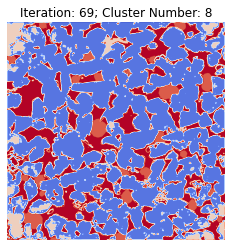

In [ ]:
title_name = 'Iteration: '+str(69)+'; '+'Cluster Number: '+str(8)
plt.imshow(im_target_rgb,cmap='coolwarm')
plt.title(title_name)
plt.axis('off')
img_name = 'IR'+str(69)+'_'+str(8)+'.tif'
fig1 = plt.gcf()
fig1.savefig(sys_path+'Figures/Intermediate_result/' + img_name, dpi=100)

In [ ]:
import imageio
images = []
filenames = os.listdir(sys_path+'Figures/Intermediate_result/')

for filename in filenames:
  images.append(imageio.imread(sys_path+'Figures/Intermediate_result/'+filename))

imageio.mimsave(sys_path+'Figures/Intermediate_result/movie.gif', images, duration = 0.5)

2. Result visualization

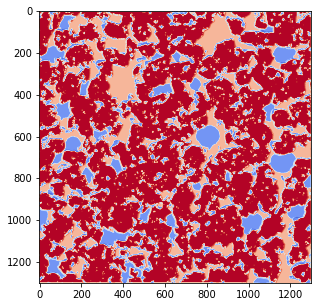

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.imshow(im_target_rgb,cmap='coolwarm')
#plt.savefig(sys_path+'Figures/Intermediate_result/' + img_name)

In [ ]:
#output_np = output.detach().numpy()
#target_np = target.detach().numpy()

#np.save(sys_path+'npy_files/RM_MyNet2_output_0_3b4s0r.npy', output_np_0)
#np.save(sys_path+'npy_files/RM_MyNet2_target_0_3b4s0r.npy', target_np_0)

#np.save(sys_path+'npy_files/RM_MyNet2_output_15_3b4s0r.npy', output_np_15)
#np.save(sys_path+'npy_files/RM_MyNet2_target_15_3b4s0r.npy', target_np_15)

#np.save(sys_path+'npy_files/RM_MyNet2_output_3b4s0r.npy', output_np)
#np.save(sys_path+'npy_files/RM_MyNet2_target_3b4s0r.npy', target_np)

Unique label: [ 4  8 13 22 25 26 27 31]
Label 4 fraction 0.2123585798816568
Label 8 fraction 0.04133491124260355
Label 13 fraction 0.013680473372781065
Label 22 fraction 0.011113609467455621
Label 25 fraction 0.024087573964497042
Label 26 fraction 0.06394556213017752
Label 27 fraction 0.009871597633136095
Label 31 fraction 0.6236076923076923


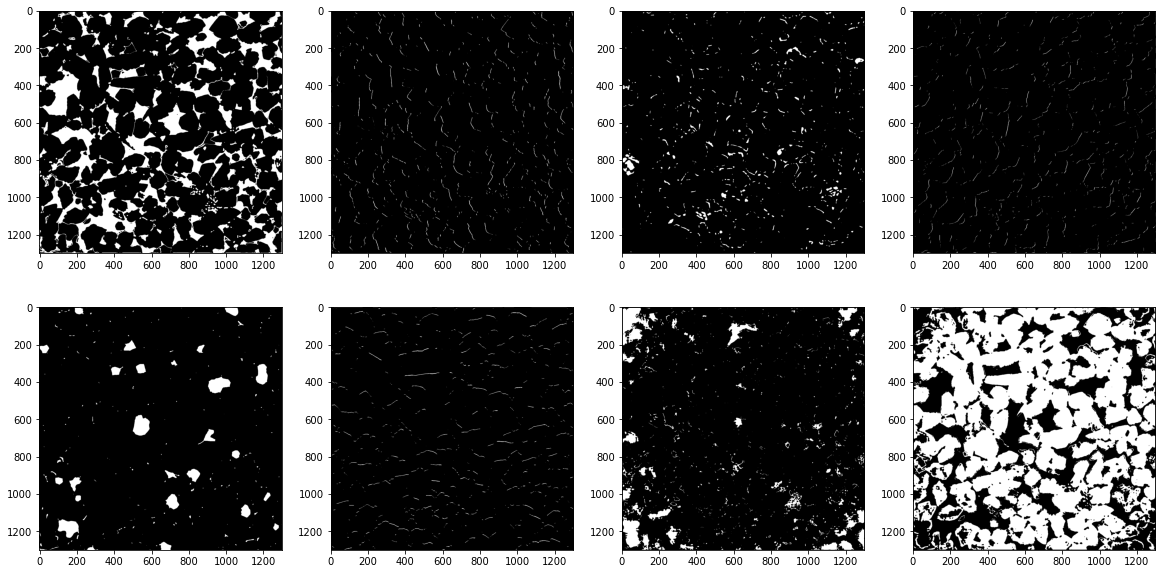

In [ ]:
output_np = output.detach().numpy()
output_label = np.unique(target)
target_np = target.detach().numpy()

print('Unique label:', output_label)
output_label.sort()
target_maps = np.zeros((1690000,8))

fig, axs = plt.subplots(2,4,figsize=(20,10))

for i in range(nLabels):
  target_maps[:,i] = (target == output_label[i])
  Label_fraction = np.sum(target_maps[:,i])/(1300*1300)
  print('Label %s fraction %s' % (output_label[i], Label_fraction))
  img_name = 'maps'+str(i)+'_106.png'
  cv2.imwrite(sys_path+'Figures/Intermediate_result/' + img_name, target_maps[:,i].reshape(1300,1300).astype( np.uint8 )*255)
  axs[i%2, i//2].imshow(target_maps[:,i].reshape(1300,1300),cmap='gray')

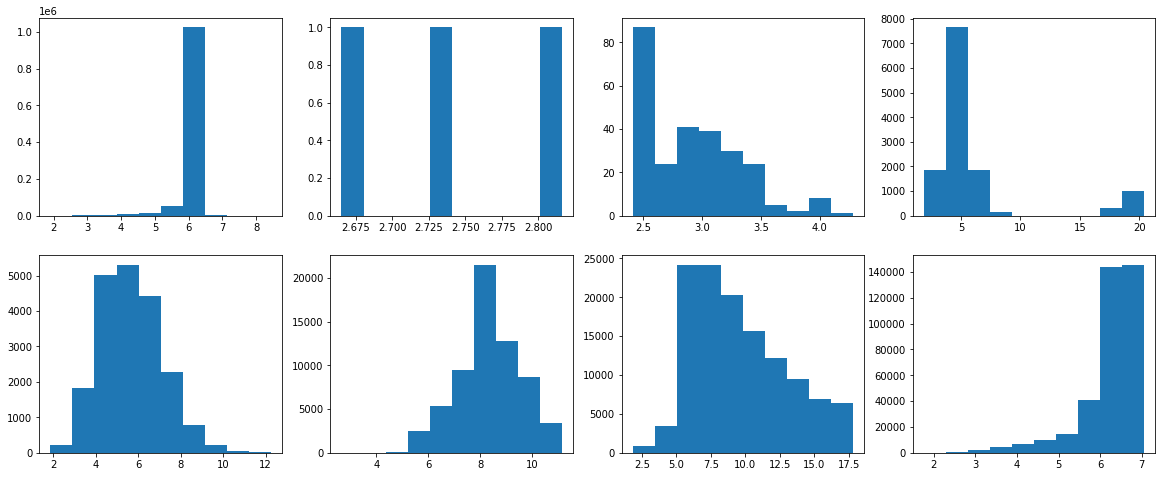

In [ ]:
fig, axs = plt.subplots(2,4,figsize=(20,8))

for i in range(nLabels):
  index = (target == output_label[i])
  axs[i%2, i//2].hist(output_np[:,output_label[i]][index])

(array([ 13393.,  12052.,  17409.,  26985.,  38263.,  55407.,  84732.,
        116476., 116013., 109467.]),
 array([-4.3624    , -3.6737971 , -2.985194  , -2.296591  , -1.6079881 ,
        -0.9193851 , -0.23078208,  0.45782092,  1.1464239 ,  1.8350269 ,
         2.52363   ], dtype=float32),
 <a list of 10 Patch objects>)

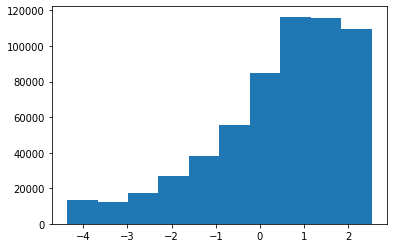

In [ ]:
index = (target == output_label[4])
plt.hist(output_np[:,output_label[2]][index])

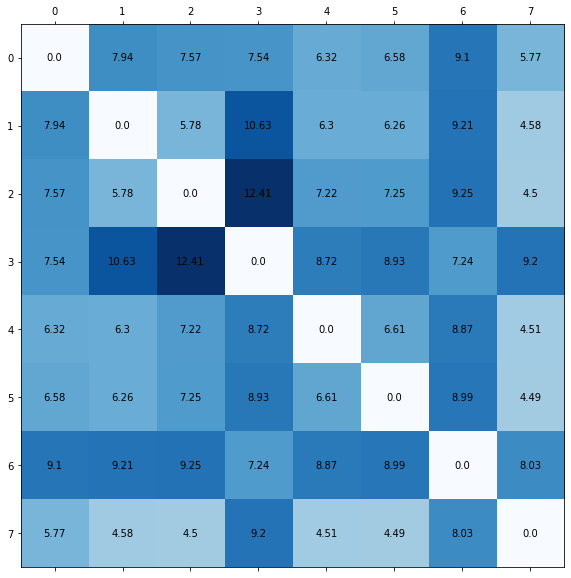

In [ ]:
Target_output_response = output_np[:,output_label[0]].reshape(1690000,1)

for i in range(7):
  mid_result = output_np[:,output_label[i+1]].reshape(1690000,1)
  Target_output_response = np.concatenate((Target_output_response,mid_result), -1)

Avg_target = np.zeros((8,8))

for i in range(8):
  index = (target == output_label[i])
  output_response_avg = np.average(Target_output_response[index],axis=0)
  Avg_target[:,i] = output_response_avg

L2_distance = np.zeros((8,8))

for i in range(8):
  Avg_target_diff = Avg_target - Avg_target[i,:]
  L2_distance[i,:] = np.round(np.sqrt(np.sum(Avg_target_diff*Avg_target_diff,1)),decimals=2)

fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(L2_distance, cmap=plt.cm.Blues)

for i in range(8):
  for j in range(8):
    c = L2_distance[j,i]
    ax.text(i, j, str(c), va='center', ha='center')

#plt.savefig(sys_path+'Figures/Intermediate_result/matrix_plot.png', dpi=600)

In [ ]:
def AHC_implement():
  minval = np.min(L2_distance[np.nonzero(L2_distance)])
  index = np.where(L2_distance == minval)
  print(index[0])

  output_label = list(output_label)

  target[output_label[index[0][1]]] = output_label[index[0][0]]
  output_label.remove(output_label[index[0][1]])

  label_len = len(output_label)

  Target_output_response = output_np[:,output_label[0]].reshape(1690000,1)
  for i in range(label_len-1):
    mid_result = output_np[:,output_label[i+1]].reshape(1690000,1)
    Target_output_response = np.concatenate((Target_output_response,mid_result), -1)

  Avg_target = np.zeros((label_len,label_len))

  for i in range(label_len):
    index = (target == output_label[i])
    output_response_avg = np.average(Target_output_response[index],axis=0)
    Avg_target[:,i] = output_response_avg

  L2_distance = np.zeros((label_len,label_len))

  for i in range(label_len):
    Avg_target_diff = Avg_target - Avg_target[i,:]
    L2_distance[i,:] = np.round(np.sqrt(np.sum(Avg_target_diff*Avg_target_diff,1)),decimals=2)

  fig, ax = plt.subplots(figsize=(10,10))
  ax.matshow(L2_distance, cmap=plt.cm.Blues)

  for i in range(label_len):
    for j in range(label_len):
      c = L2_distance[j,i]
      ax.text(i, j, str(c), va='center', ha='center')

(1300, 1300)

# **Run main codes for multiple times**

In [ ]:
for i in range(500):
  seg_process(i)

# **Analyze noise impact**

In [ ]:
file_name = Noise_analysis_path+'GT.png'

Data synthesis

True

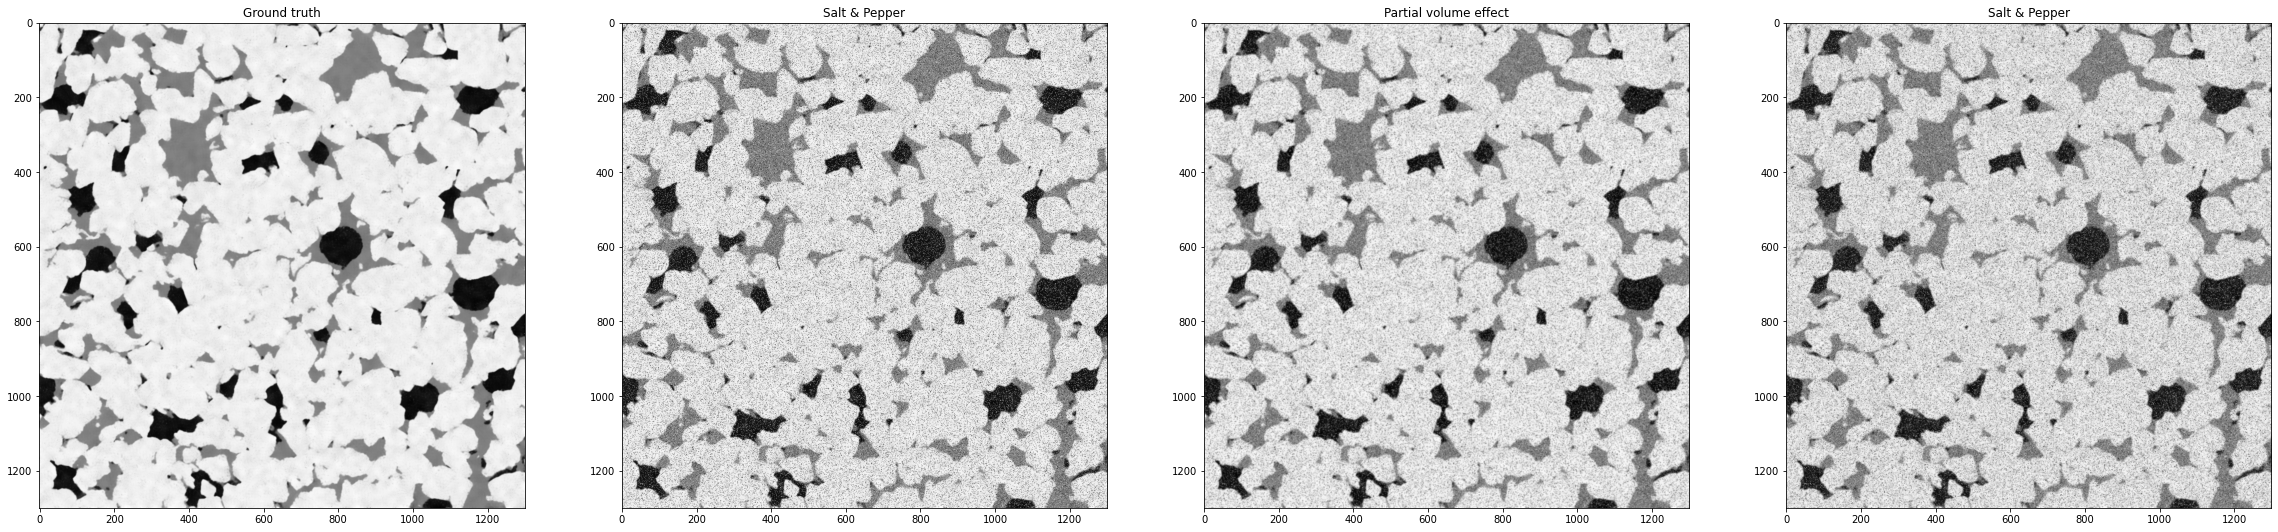

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(40, 10))
im_GT = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)

ax[0].imshow(im_GT, cmap='gray')
ax[0].set_title('Ground truth')

im_GT[im_GT == 0] = 85
im_GT[im_GT == 255] = 170

im_SP = sp_noise(im_GT,0.075)
im_SP[im_SP<0] = 0
im_SP[im_SP>255] = 255
ax[1].imshow(im_SP, cmap='gray')
ax[1].set_title('Salt & Pepper')

gauss_kernel = Gaussian2DKernel(1)
im_PVE = convolve(im_SP, gauss_kernel, normalize_kernel=True, boundary='extend')
ax[2].imshow(im_PVE,cmap='gray')
ax[2].set_title('Partial volume effect')
im_PVE = im_PVE.astype('uint8')

im_SP = sp_noise(im_PVE,0.02)
im_SP[im_SP<0] = 0
im_SP[im_SP>255] = 255
ax[3].imshow(im_SP, cmap='gray')
ax[3].set_title('Salt & Pepper')

im_Synthetic = im_SP
cv2.imwrite(Noise_analysis_path + 'SyntheticData_0530.tif', im_Synthetic)

In [ ]:
Noise_analysis_path

'/content/gdrive/My Drive/Unsupervised_Learning/Figures/SyntheticData/'

Data preview

Text(0.5, 1.0, 'Synthetic data')

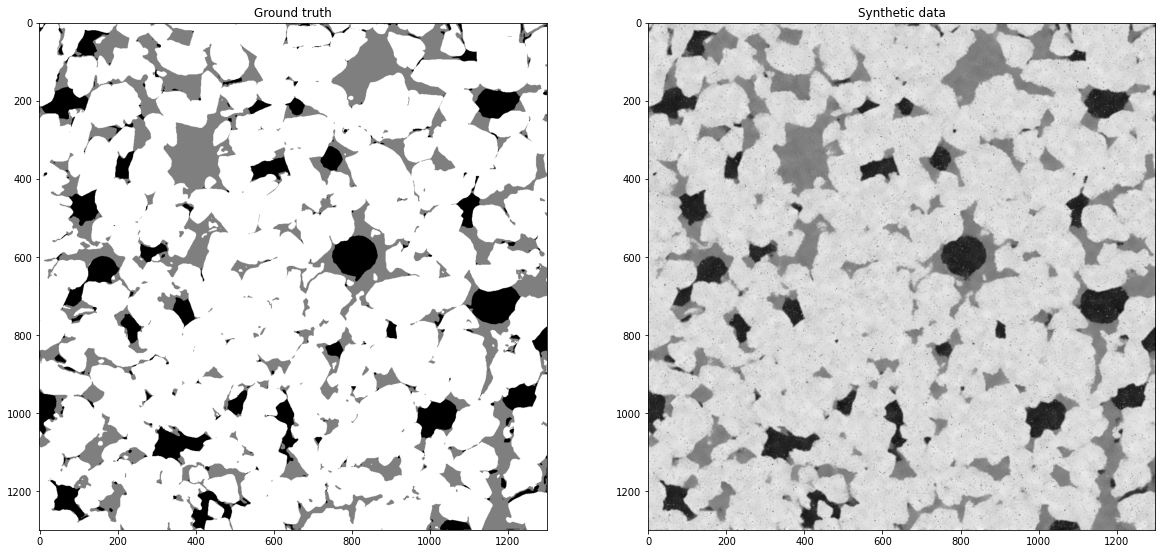

In [ ]:
#im_Noise = cv2.imread(Noise_analysis_path + 'SyntheticData_0526_2.tif', cv2.IMREAD_GRAYSCALE)
im_Noise = cv2.imread(Noise_analysis_path + 'Pre-process.png', cv2.IMREAD_GRAYSCALE)
im_GT = cv2.imread(Noise_analysis_path + 'GT.png', cv2.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].imshow(im_GT, cmap='gray')
ax[0].set_title('Ground truth')
ax[1].imshow(im_Noise, cmap='gray')
ax[1].set_title('Synthetic data')

1. Multi-Otsu method

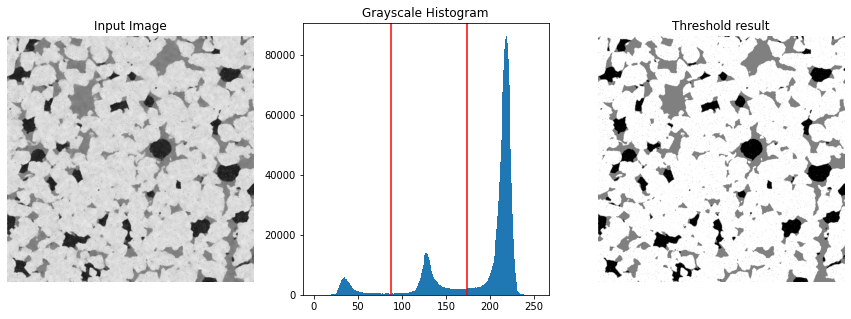

Segmentation time:
0.9543936252593994
Threshold segmentation accuracy:
0.9562721893491124


True

In [ ]:
start = time.time()

thresholds = threshold_multiotsu(im_Noise)
regions = np.digitize(im_Noise, bins=thresholds)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plotting the original image.
ax[0].imshow(im_Noise, cmap='gray')
ax[0].set_title('Input Image')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(im_Noise.ravel(), bins=255)
ax[1].set_title('Grayscale Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='gray')
ax[2].set_title('Threshold result')
ax[2].axis('off')

plt.subplots_adjust()
plt.show()

end = time.time()

print('Segmentation time:')
print(end-start)

regions[regions == 1] = 127
regions[regions == 2] = 255

compare_MultiT = (regions == im_GT)
print('Threshold segmentation accuracy:')
print(np.sum(compare_MultiT)/(1300*1300))

cv2.imwrite(sys_path+'Figures/Model_comparison/' + 'MultiT.tif', regions)

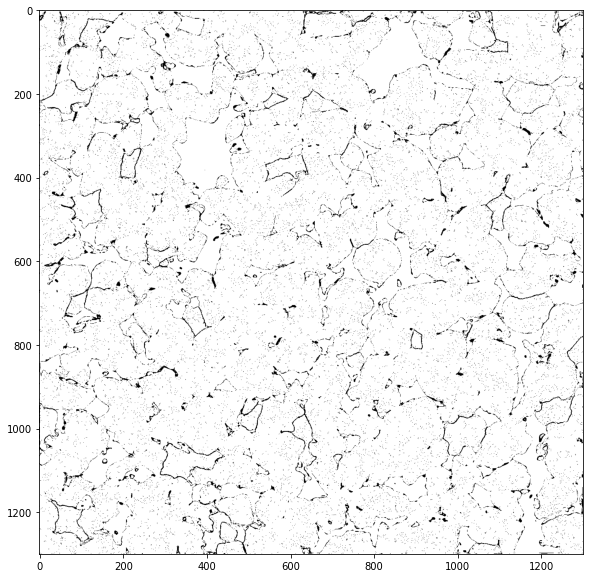

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(regions == im_GT, cmap = 'gray')

In [ ]:
label_true_flatten = im_GT.reshape(1300*1300,1)
label_pred_flatten = regions.reshape(1300*1300,1)

model_evaluation(label_true_flatten,label_pred_flatten)


Classification Report

              precision    recall  f1-score   support

       scCO2     0.9598    0.8726    0.9141    116652
       brine     0.8290    0.9224    0.8732    263386
        rock     0.9849    0.9705    0.9777   1309962

    accuracy                         0.9563   1690000
   macro avg     0.9246    0.9218    0.9217   1690000
weighted avg     0.9589    0.9563    0.9570   1690000



True

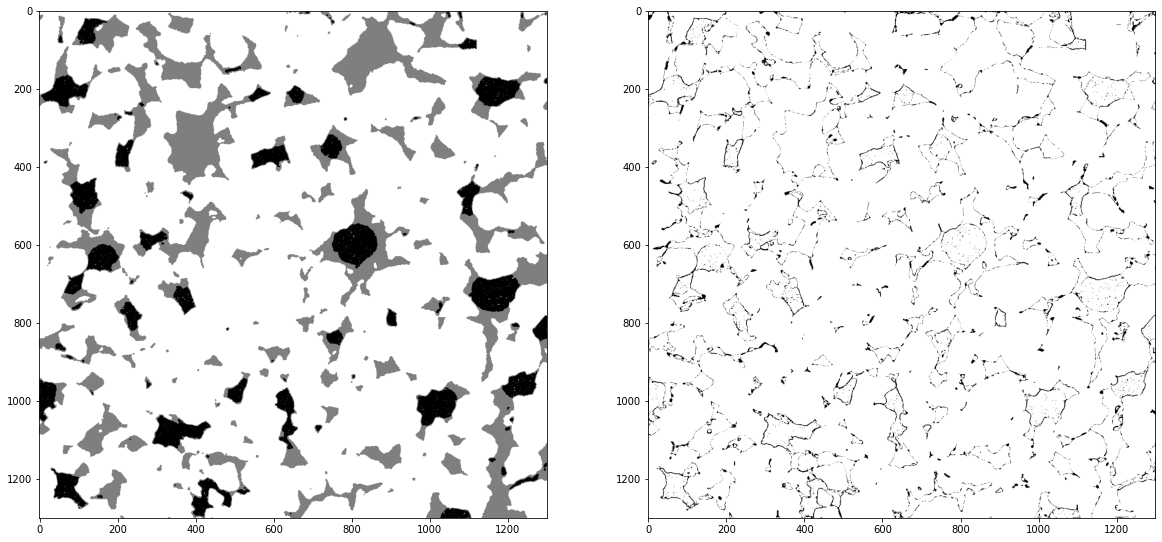

In [ ]:
im_MultiT = cv2.imread(sys_path+'Figures/Model_comparison/' + 'MultiT.tif', cv2.IMREAD_GRAYSCALE)
kernel = np.ones((3,3),np.uint8)
MultiT_closing = cv2.morphologyEx(im_MultiT, cv2.MORPH_CLOSE, kernel)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].imshow(MultiT_closing, cmap = 'gray')
manual_compare = (MultiT_closing == im_GT)*255
ax[1].imshow(MultiT_closing == im_GT, cmap = 'gray')

cv2.imwrite(sys_path+'Figures/Model_comparison/' + 'Manual.tif', MultiT_closing)
cv2.imwrite(sys_path+'Figures/Model_comparison/' + 'Manual_diff.tif', manual_compare.astype('uint8'))

In [ ]:
label_true_flatten = im_GT.reshape(1300*1300,1)
label_pred_flatten = MultiT_closing.reshape(1300*1300,1)

model_evaluation(label_true_flatten,label_pred_flatten)


Classification Report

              precision    recall  f1-score   support

       scCO2     0.9862    0.8591    0.9183    116652
       brine     0.8735    0.9197    0.8960    263386
        rock     0.9841    0.9849    0.9845   1309962

    accuracy                         0.9661   1690000
   macro avg     0.9479    0.9212    0.9329   1690000
weighted avg     0.9670    0.9661    0.9662   1690000



2. K-means clustering

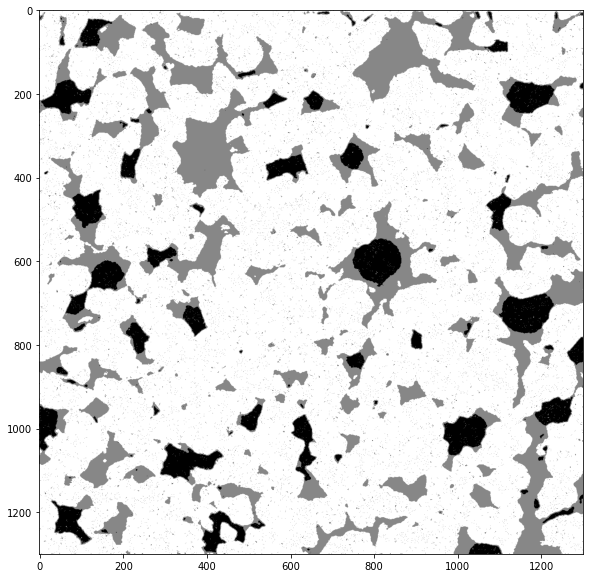

Segmentation time:
1.4813427925109863
K-means clustering segmentation accuracy:
0.9554183431952663


True

In [ ]:
start = time.time()

image = im_Noise.reshape(1300,1300,1)
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pixel_values = image.reshape((-1, 1))
pixel_values = np.float32(pixel_values)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 3
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)
labels = labels.flatten()
segmented_image = centers[labels.flatten()]

segmented_image = segmented_image.reshape(image.shape)
# show the image
plt.figure(figsize=(10, 10))
plt.imshow(segmented_image.reshape(1300,1300),cmap='gray')
plt.show()

end = time.time()

print('Segmentation time:')
print(end-start)

a = np.unique(segmented_image)

segmented_image[segmented_image == a[0]] = 0
segmented_image[segmented_image == a[1]] = 127
segmented_image[segmented_image == a[2]] = 255

compare_knn = (segmented_image[:,:,0] == im_GT)
np.sum(compare_knn)/(1300*1300)
print('K-means clustering segmentation accuracy:')
print(np.sum(compare_knn)/(1300*1300))

cv2.imwrite(sys_path+'Figures/Model_comparison/' + 'KMeans.tif', segmented_image[:,:,0])

True

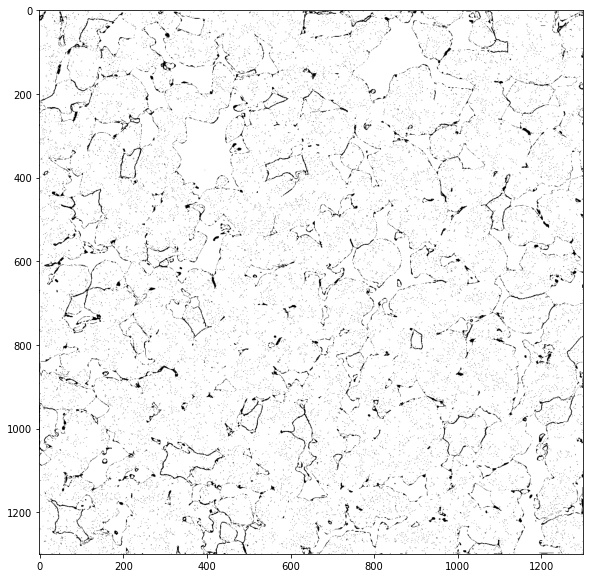

In [ ]:
plt.figure(figsize=(10, 10))
kmeans_compare = (segmented_image[:,:,0] == im_GT)*255
plt.imshow(kmeans_compare, cmap = 'gray')

cv2.imwrite(sys_path+'Figures/Model_comparison/' + 'KMeans_diff.tif', kmeans_compare.astype('uint8'))

In [ ]:
label_true_flatten = im_GT.reshape(1300*1300,1)
label_pred_flatten = segmented_image[:,:,0].reshape(1300*1300,1)

model_evaluation(label_true_flatten,label_pred_flatten)


Classification Report

              precision    recall  f1-score   support

       scCO2     0.9589    0.8751    0.9151    116652
       brine     0.8222    0.9271    0.8715    263386
        rock     0.9859    0.9683    0.9770   1309962

    accuracy                         0.9554   1690000
   macro avg     0.9223    0.9235    0.9212   1690000
weighted avg     0.9585    0.9554    0.9563   1690000



3. Watershed

True

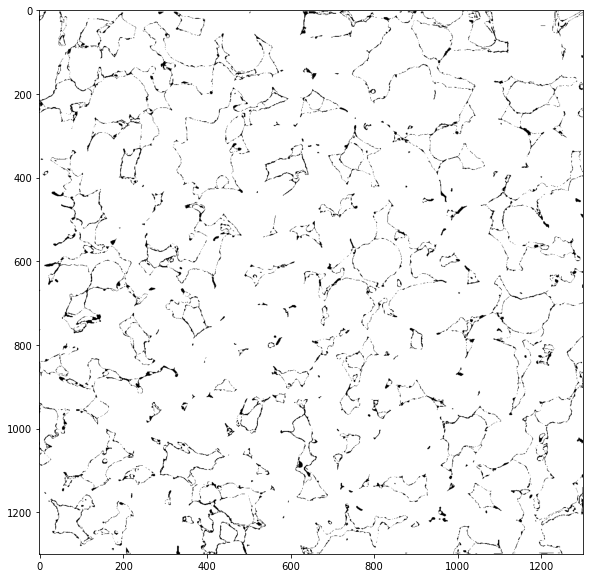

In [ ]:
im_watershed = cv2.imread(sys_path+'Figures/Model_comparison/' + 'watershed.png', cv2.IMREAD_GRAYSCALE)
compare_watershed = (im_watershed == im_GT)*255
plt.figure(figsize=(10, 10))
plt.imshow(compare_watershed, cmap='gray')

cv2.imwrite(sys_path+'Figures/Model_comparison/' + 'Watershed_diff.tif', compare_watershed.astype('uint8'))

In [ ]:
label_true_flatten = im_GT.reshape(1300*1300,1)
label_pred_flatten = im_watershed.reshape(1300*1300,1)

model_evaluation(label_true_flatten,label_pred_flatten)


Classification Report

              precision    recall  f1-score   support

       scCO2     0.9548    0.9056    0.9295    116652
       brine     0.8893    0.8903    0.8898    263386
        rock     0.9805    0.9848    0.9827   1309962

    accuracy                         0.9646   1690000
   macro avg     0.9415    0.9269    0.9340   1690000
weighted avg     0.9645    0.9646    0.9645   1690000



4. SLIC

True

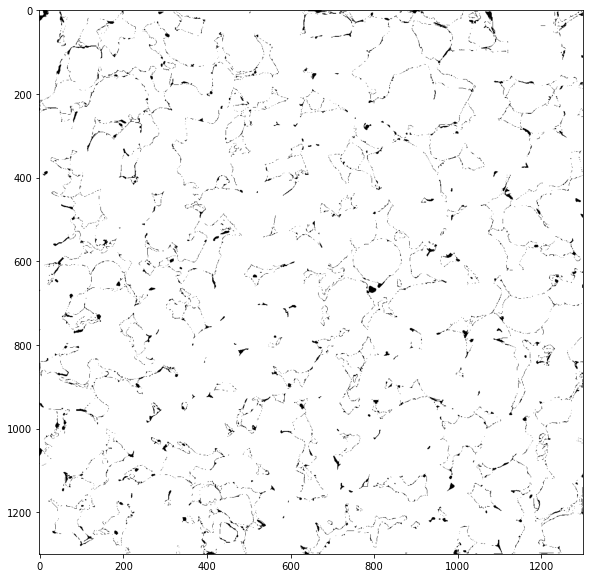

In [ ]:
im_slic = cv2.imread(sys_path+'Figures/Model_comparison/' + 'unsupervised_slic.tif', cv2.IMREAD_GRAYSCALE)
compare_slic = (im_slic == im_GT)*255
plt.figure(figsize=(10, 10))
plt.imshow(compare_slic, cmap='gray')

cv2.imwrite(sys_path+'Figures/Model_comparison/' + 'SLIC_diff.tif', compare_slic.astype('uint8'))

In [ ]:
label_true_flatten = im_GT.reshape(1300*1300,1)
label_pred_flatten = im_slic.reshape(1300*1300,1)

model_evaluation(label_true_flatten,label_pred_flatten)


Classification Report

              precision    recall  f1-score   support

       scCO2     0.9703    0.9120    0.9402    116652
       brine     0.9174    0.9373    0.9272    263386
        rock     0.9874    0.9884    0.9879   1309962

    accuracy                         0.9751   1690000
   macro avg     0.9584    0.9459    0.9518   1690000
weighted avg     0.9753    0.9751    0.9751   1690000



'/content/gdrive/My Drive/Unsupervised_Learning/Figures/Model_comparison'

5. Target method

Text(0.5, 1.0, 'After')

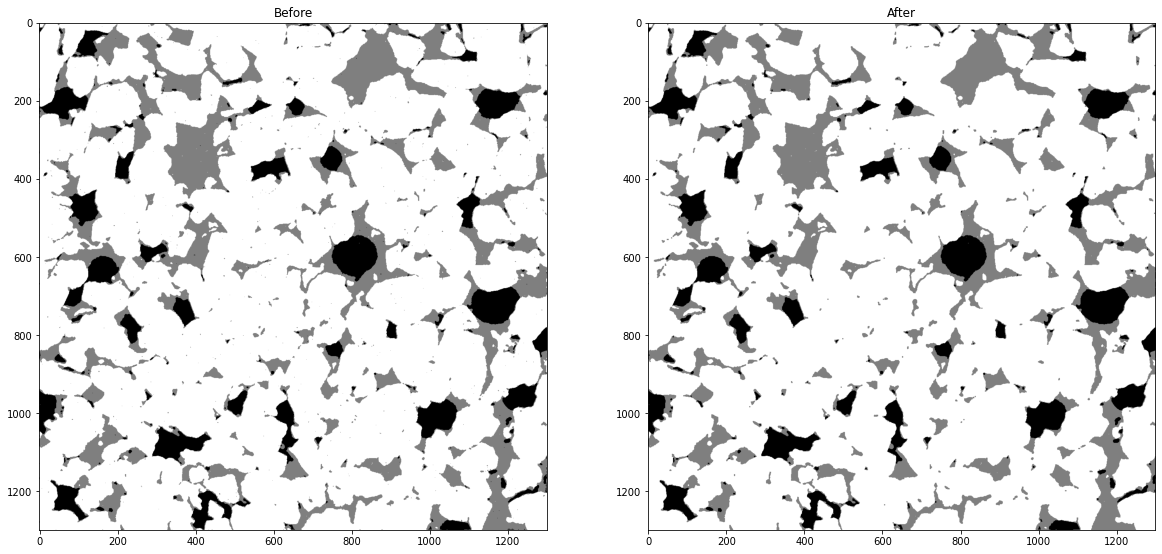

In [ ]:
im_unsupervised = cv2.imread(sys_path + 'unsupervised_0526_2_4.tif', cv2.IMREAD_GRAYSCALE)
kernel = np.ones((3,3),np.uint8)
closing = cv2.morphologyEx(im_unsupervised, cv2.MORPH_CLOSE, kernel)
cv2.imwrite(sys_path+'Figures/Model_comparison/' + 'unsupervised_closing.tif', closing)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].imshow(im_unsupervised, cmap='gray')
ax[0].set_title('Before')
ax[1].imshow(closing, cmap='gray')
ax[1].set_title('After')

True

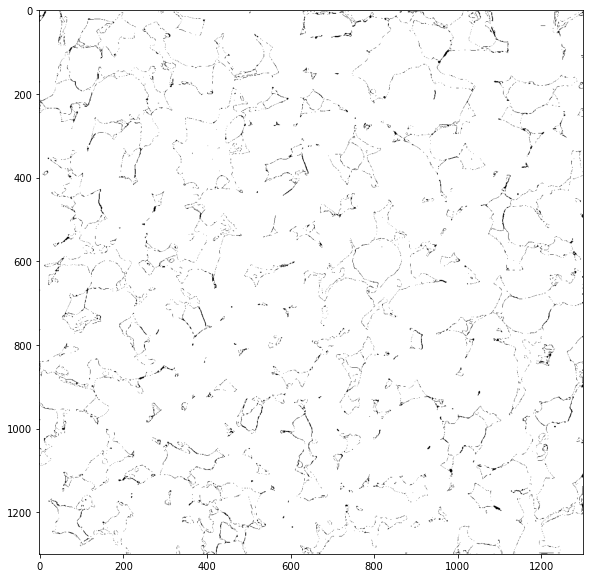

In [ ]:
compare_unsupervised = (closing == im_GT)*255
plt.figure(figsize=(10, 10))
plt.imshow(compare_unsupervised, cmap='gray')

cv2.imwrite(sys_path+'Figures/Model_comparison/' + 'unsupervised_diff.tif', compare_unsupervised.astype('uint8'))

In [ ]:
label_true_flatten = im_GT.reshape(1300*1300,1)
#label_pred_flatten = im_unsupervised.reshape(1300*1300,1)
label_pred_flatten = closing.reshape(1300*1300,1)

model_evaluation(label_true_flatten,label_pred_flatten)


Classification Report

              precision    recall  f1-score   support

       scCO2     0.9770    0.9455    0.9610    116652
       brine     0.9367    0.9540    0.9453    263386
        rock     0.9920    0.9912    0.9916   1309962

    accuracy                         0.9823   1690000
   macro avg     0.9686    0.9636    0.9660   1690000
weighted avg     0.9824    0.9823    0.9823   1690000



# **3D image construction and split**

In [ ]:
def resize_data(data, new_size_1,new_size_2,new_size_3):
    initial_size_x = data.shape[0]
    initial_size_y = data.shape[1]
    initial_size_z = data.shape[2]

    new_size_x = new_size_1
    new_size_y = new_size_2
    new_size_z = new_size_3

    delta_x = initial_size_x / new_size_x
    delta_y = initial_size_y / new_size_y
    delta_z = initial_size_z / new_size_z

    new_data = np.zeros((new_size_x, new_size_y, new_size_z))

    for x, y, z in itertools.product(range(new_size_x),
                                     range(new_size_y),
                                     range(new_size_z)):
        new_data[x][y][z] = data[int(x * delta_x)][int(y * delta_y)][int(z * delta_z)]

    return new_data

In [ ]:
img_data = np.ndarray((500, 1300, 1300), dtype=np.float32)

for i in range(500):
  file_name = img_path + 'Seg_img_500/'+str(250+i).zfill(4)+'.png'
  im = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE) # Read image: 1300 1300 1
  img_data[i,:,:] = im

In [ ]:
img_data[img_data == 0] = 2
img_data[img_data == 255] = 1
img_data[img_data == 127] = 0

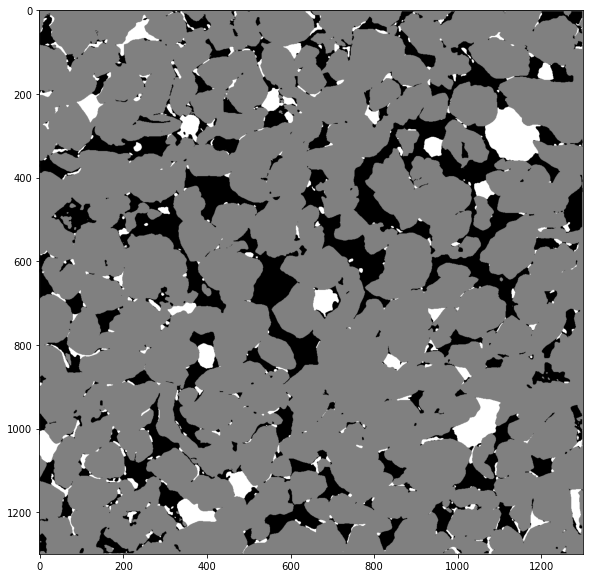

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(img_data[0,:,:],cmap='gray')

In [ ]:
img_resize_300 = resize_data(img_data,250,650,650)

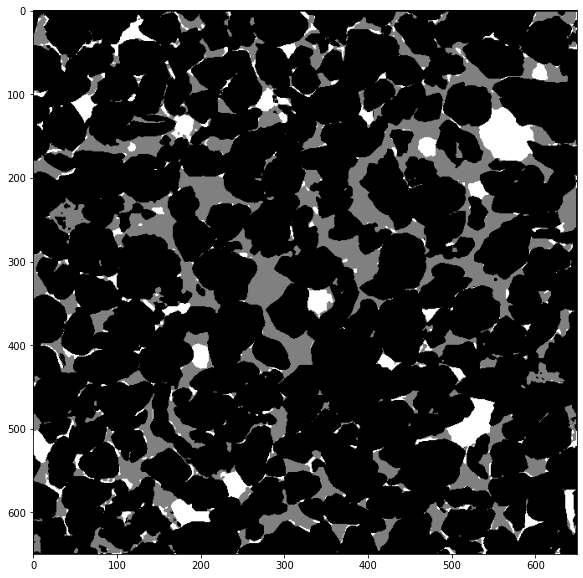

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(img_resize_300[0,:,:],cmap='gray')

In [ ]:
np.unique(img_resize_300)

array([0., 1., 2.])

In [ ]:
raw_sub_vol2 = img_path+'img_resize_original.raw'
img_data_sub_1 = img_data[100:350,325:650,325:650]
img_data_sub_1.astype('uint8').tofile(raw_sub_vol2)

In [ ]:
raw_file_name = img_path+'img_resize_500.raw'
img_resize.astype('uint8').tofile(raw_file_name)

In [ ]:
raw_sub_vol2 = img_path+'img_resize_2.raw'
img_data_sub_1 = img_resize_300[:,325:650,0:325]
img_data_sub_1.astype('uint8').tofile(raw_sub_vol2)

raw_sub_vol3 = img_path+'img_resize_3.raw'
img_data_sub_1 = img_resize_300[:,0:325,325:650]
img_data_sub_1.astype('uint8').tofile(raw_sub_vol3)

raw_sub_vol4 = img_path+'img_resize_4.raw'
img_data_sub_1 = img_resize_300[:,325:650,325:650]
img_data_sub_1.astype('uint8').tofile(raw_sub_vol4)

In [ ]:
ID = np.fromfile(img_path+'img_500_2.raw',dtype=np.uint8)

In [ ]:
ID_1 = ID.reshape(500,650,650)

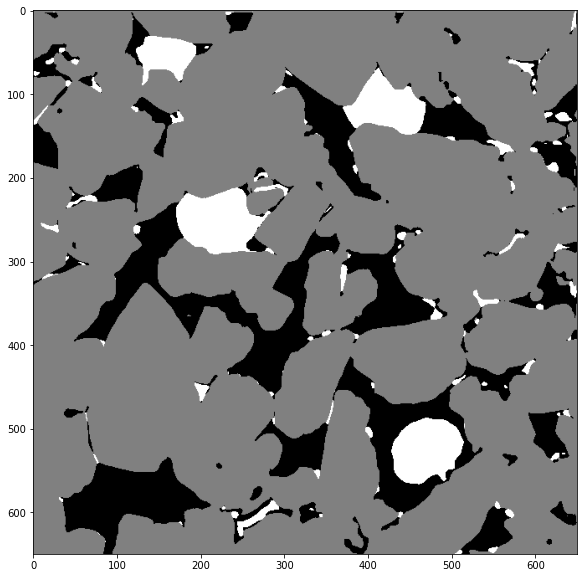

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(ID_1[100,:,:],cmap='gray')

In [ ]:
ID_ex = np.fromfile(sys_path+'Sample1_subvolume.raw',dtype=np.uint8)

In [ ]:
ID_ex = ID_ex.reshape(126,97,105)

In [ ]:
np.unique(img_data_sub_1)

array([0., 1., 2.])

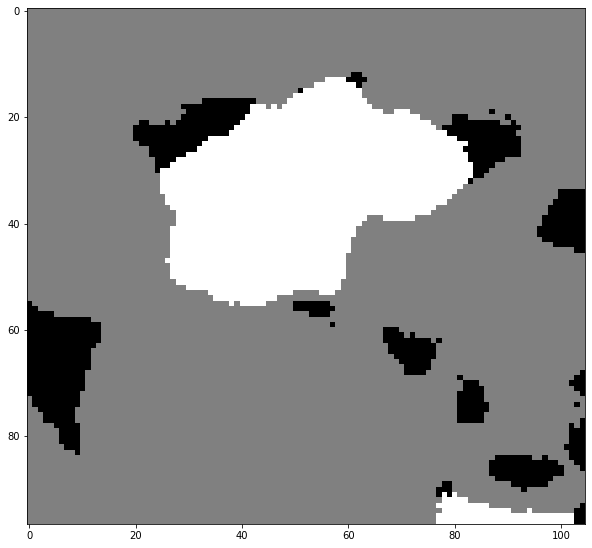

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(ID_ex[55,:,:],cmap='gray')

# **Backup codes**

In [ ]:
index = 3
index_prefix = str(index).zfill(4)
seg_matrix_list = [f for f in os.listdir(seg_result_qualified_path) if f.startswith(index_prefix)]
seg_matrix_name = seg_matrix_list[0]

seg_matrix_file = seg_matrix_name.split('_')
img_num = seg_matrix_file[0]
filter_num = int(seg_matrix_file[1].split('.')[0])
seg_result = np.load(seg_result_qualified_path + seg_matrix_name)

seg_visualize_button = widgets.Button(description="Segmentation Result", layout=Layout(width='50%', height='40px'))
output = widgets.Output()

# image_num depends on the outputs
def seg_visualize_button_clicked(b, image_num=filter_num):
# def pre_binary_slice_button_clicked(b, image_num=20):
  with output:
    clear_output(wait=True)
    seg_visualize(image_num)

seg_visualize_button.on_click(seg_visualize_button_clicked)
button = widgets.HBox([seg_visualize_button])
display(button, output)

Output()

In [ ]:
# parameter not optimized

def run(file_name):
  
  start = time.time()

  args = Args()
  torch.cuda.manual_seed_all(1943)
  np.random.seed(1943)
  os.environ['CUDA_VISIBLE_DEVICES'] = str(args.gpu_id)  # choose GPU:0
  im = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE) # Read image: 1300 1300 1
  # im = cv2.imread(args.input) # Read image: 1300 1300 1
  im = im.reshape(1300,1300,1)
  data = torch.from_numpy( np.array([im.transpose( (2, 0, 1) ).astype('float32')/255.]) ) # size: 1 1 1300 1300
  use_cuda = torch.cuda.is_available()

  if use_cuda:
    data = data.cuda()
  
  data = Variable(data) # size: 1 1 1300 1300
  device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

  model = MyNet(inp_dim=1, mod_dim1=args.mod_dim1, mod_dim2=args.mod_dim2, mod_dim3=args.mod_dim3, mod_dim4=args.mod_dim4).to(device)

  if use_cuda:
    model.cuda()

  model.train()

  # similarity loss definition
  loss_fn = torch.nn.CrossEntropyLoss() 

  # scribble loss definition
  loss_fn_scr = torch.nn.CrossEntropyLoss()

  # continuity loss definition
  loss_hpy = torch.nn.L1Loss(size_average = True)
  loss_hpz = torch.nn.L1Loss(size_average = True)
  #loss_hpy = torch.nn.MSELoss(size_average = True)
  #loss_hpz = torch.nn.MSELoss(size_average = True)

  HPy_target1 = torch.zeros(im.shape[0]-1, im.shape[1], args.mod_dim_output) # 1299, 1300, 32
  HPz_target1 = torch.zeros(im.shape[0], im.shape[1]-1, args.mod_dim_output) # 1300, 1299, 32

  HPy_target2 = torch.zeros(im.shape[0]-2, im.shape[1], args.mod_dim_output) # 1299, 1300, 32
  HPz_target2 = torch.zeros(im.shape[0], im.shape[1]-2, args.mod_dim_output) # 1300, 1299, 32

  HPy_target3 = torch.zeros(im.shape[0]-3, im.shape[1], args.mod_dim_output) # 1299, 1300, 32
  HPz_target3 = torch.zeros(im.shape[0], im.shape[1]-3, args.mod_dim_output) # 1300, 1299, 32

  if use_cuda:
    HPy_target1 = HPy_target1.cuda()
    HPz_target1 = HPz_target1.cuda()

    HPy_target2 = HPy_target2.cuda()
    HPz_target2 = HPz_target2.cuda()

    HPy_target3 = HPy_target3.cuda()
    HPz_target3 = HPz_target3.cuda()
    
  optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)
  label_colours = np.random.randint(255,size=(args.mod_dim_output,1)) # Modify to ordered colours

  for batch_idx in range(args.maxIter):
    # forwarding
    optimizer.zero_grad()
    output = model( data )[0]
    output = output.permute( 1, 2, 0 ).contiguous().view( -1, args.mod_dim_output)

    outputHP = output.reshape( (im.shape[0], im.shape[1], args.mod_dim_output) )
    HPy1 = outputHP[1:, :, :] - outputHP[0:-1, :, :]
    HPz1 = outputHP[:, 1:, :] - outputHP[:, 0:-1, :]

    HPy2 = outputHP[2:, :, :] - outputHP[0:-2, :, :]
    HPz2 = outputHP[:, 2:, :] - outputHP[:, 0:-2, :]

    HPy3 = outputHP[3:, :, :] - outputHP[0:-3, :, :]
    HPz3 = outputHP[:, 3:, :] - outputHP[:, 0:-3, :]

    lhpy1 = loss_hpy(HPy1,HPy_target1)
    lhpz1 = loss_hpz(HPz1,HPz_target1)

    lhpy2 = loss_hpy(HPy2,HPy_target2)
    lhpz2 = loss_hpz(HPz2,HPz_target2)

    lhpy3 = loss_hpy(HPy3,HPy_target3)
    lhpz3 = loss_hpz(HPz3,HPz_target3)

    ignore, target = torch.max( output, 1 )
    im_target = target.data.cpu().numpy()
    nLabels = len(np.unique(im_target))

    # loss 
    if args.scribble:
      loss = args.stepsize_sim * loss_fn(output[ inds_sim ], target[ inds_sim ]) + args.stepsize_scr * loss_fn_scr(output[ inds_scr ], \
          target_scr[ inds_scr ]) + args.stepsize_con * (lhpy + lhpz)
    else:
      loss = args.stepsize_sim * loss_fn(output, target) + args.stepsize_con * (lhpy3 + lhpz3)
      # loss = args.stepsize_sim * loss_fn(output, target) + args.stepsize_con * (lhpy1 + lhpy2 + lhpy3)
        
    loss.backward()
    optimizer.step()

    print (batch_idx, '/', args.maxIter, '|', ' label num :', nLabels, ' | loss :', loss.item())

    if nLabels <= args.minLabels:
      print ("nLabels", nLabels, "reached minLabels", args.minLabels, ".")
      break

  # save output image
  if not args.visualize:
    output = model( data )[ 0 ]
    output = output.permute( 1, 2, 0 ).contiguous().view( -1, args.mod_dim_output )
    ignore, target = torch.max( output, 1 )
    im_target = target.data.cpu().numpy()
    im_target_rgb = np.array([label_colours[ c % args.mod_dim_output] for c in im_target])
    im_target_rgb = im_target_rgb.reshape( im.shape ).astype( np.uint8 )

  end = time.time()
  print('Running time: ', end-start, ' s')
  cv2.imwrite(sys_path + "output.tif", im_target_rgb)
  return im_target_rgb

In [ ]:
img_num = 0
file_name = img_path+'Cropped_Filtered/cycle-2-cropped-filtered' + str(img_num).zfill(4) + '.tif'
im = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)
para_matrix = np.zeros((50, 8))
filter_num = 0

  for iter_num in tqdm(range(1)):
    run(file_name)

    im_target_rgb = cv2.imread(sys_path+'output.tif', cv2.IMREAD_GRAYSCALE)
    target_label = np.unique(im_target_rgb)
    im_label_mean = np.zeros(len(target_label))

    for i in range(len(target_label)):
      a = (im_target_rgb == target_label[i])
      b = a * im
      c = np.nonzero(b)
      non_num = len(c[0])
      if non_num == 0:
        pass
      else: 
        im_label_mean[i] = int(np.sum(b[:])/non_num)
        im_target_rgb[im_target_rgb == target_label[i]] = im_label_mean[i]

    cv2.imwrite(sys_path + "output_mean.tif", im_target_rgb)
    im_label_mean.sort()

    if len(im_label_mean) > 8:
      para_matrix[iter_num, :] = im_label_mean[0:8]
    else:
      im_label_supp = np.zeros(8-len(im_label_mean))
      im_label_mean = np.concatenate((im_label_mean, im_label_supp))
      para_matrix[iter_num, :] = im_label_mean

    co2_index = 1
    solid_index = 1

    if im_label_mean[0] > 50:
      co2_index = 0

    if im_label_mean[2] < 135:
      solid_index = 0

    filter_index = co2_index * solid_index

    if filter_index:
      print('Filtering condition satisfied:')
      print(iter_num)
      print(im_label_mean)
      im_target_rgb = im_target_rgb.reshape(1300,1300,1)

      im_target_rgb[im_target_rgb == im_label_mean[0]] = 0
      im_target_rgb[im_target_rgb > (im_label_mean[2]-1)] = 255
      im_target_rgb[im_target_rgb == im_label_mean[1]] = 127

      if filter_num == 0:
        seg_result = im_target_rgb
      else:
        seg_result = np.dstack((seg_result, im_target_rgb))

      filter_num += 1

  cv2.imwrite(sys_path + "output_three.tif", im_target_rgb)
  np.save(img_path + str(img_num).zfill(4) + '_' + str(filter_num) + '.npy', seg_result)

In [ ]:
HPy_target1 = torch.zeros(im.shape[0]-1, im.shape[1], args.mod_dim_output) # 1297, 1300, 32
HPz_target1 = torch.zeros(im.shape[0], im.shape[1]-1, args.mod_dim_output) # 1300, 1297, 32

HPy_target2 = torch.zeros(im.shape[0]-2, im.shape[1], args.mod_dim_output) # 1299, 1300, 32
HPz_target2 = torch.zeros(im.shape[0], im.shape[1]-2, args.mod_dim_output) # 1300, 1299, 32

HPy_target4 = torch.zeros(im.shape[0]-4, im.shape[1], args.mod_dim_output) # 1299, 1300, 32
HPz_target4 = torch.zeros(im.shape[0], im.shape[1]-4, args.mod_dim_output) # 1300, 1299, 32

HPy_target5 = torch.zeros(im.shape[0]-5, im.shape[1], args.mod_dim_output) # 1298, 1300, 32
HPz_target5 = torch.zeros(im.shape[0], im.shape[1]-5, args.mod_dim_output) # 1300, 1298, 32

if use_cuda:
  HPy_target1 = HPy_target1.cuda()
  HPz_target1 = HPz_target1.cuda()

  HPy_target2 = HPy_target2.cuda()
  HPz_target2 = HPz_target2.cuda()

  HPy_target4 = HPy_target4.cuda()
  HPz_target4 = HPz_target4.cuda()

  HPy_target5 = HPy_target5.cuda()
  HPz_target5 = HPz_target5.cuda()

HPy1 = outputHP[1:, :, :] - outputHP[0:-1, :, :]
HPz1 = outputHP[:, 1:, :] - outputHP[:, 0:-1, :]

HPy2 = outputHP[2:, :, :] - outputHP[0:-2, :, :]
HPz2 = outputHP[:, 2:, :] - outputHP[:, 0:-2, :]

HPy4 = outputHP[4:, :, :] - outputHP[0:-4, :, :]
HPz4 = outputHP[:, 4:, :] - outputHP[:, 0:-4, :]

HPy5 = outputHP[5:, :, :] - outputHP[0:-5, :, :]
HPz5 = outputHP[:, 5:, :] - outputHP[:, 0:-5, :]

lhpy1 = loss_hpy(HPy1,HPy_target1)
lhpz1 = loss_hpz(HPz1,HPz_target1)

lhpy2 = loss_hpy(HPy2,HPy_target2)
lhpz2 = loss_hpz(HPz2,HPz_target2)

lhpy4 = loss_hpy(HPy4,HPy_target4)
lhpz4 = loss_hpz(HPz4,HPz_target4)

lhpy5 = loss_hpy(HPy5,HPy_target5)
lhpz5 = loss_hpz(HPz5,HPz_target5)

In [ ]:
fig, axs = plt.subplots(2,4,figsize=(30,15))
Label_values = np.unique(im_target_rgb)
nLabels = len(np.unique(im_target_rgb))

for i in range(nLabels):
  axs[i%2, i//2].imshow(score_high_array_sigmoid[:,:,i],cmap='gray')




fig, axs = plt.subplots(2,4,figsize=(30,15))
Label_values = np.unique(im_target_rgb)
nLabels = len(np.unique(im_target_rgb))

for i in range(nLabels):
  axs[i%2, i//2].imshow(score_high_array_softmax[:,:,i],cmap='gray')




score_map_2 = output_old.reshape(1300,1300,32)
target_map_2 = target_old.reshape(1300,1300)

im_target_2 = target_old.data.cpu().numpy()
target_label_2 = np.unique(im_target_2)

score_high_2 = score_map_2[:,:,target_label_2]
score_high_array_2 = score_high_2.data.cpu().numpy()

score_high_array_sigmoid_2 = 1/(1+np.exp(-score_high_array_2))
score_high_array_softmax_2 = softmax(score_high_array_2,axis=2)

test_2 = np.zeros([1300,1300])

for i in range(1300):
  for j in range(1300):
    if sorted(score_high_array_sigmoid_2[i,j,:], reverse=True)[1] > 0.99:
      test_2[i,j] = 1
    else:
      pass

plt.figure(figsize=(10,10))
plt.imshow(test_2)


im_target_rgb_1 = im_target_rgb_old

print(len(np.unique(im_target_rgb_1)))

fig, axs = plt.subplots(2,4,figsize=(30,15))
Label_values = np.unique(im_target_rgb_1)
nLabels = len(np.unique(im_target_rgb_1))

for i in range(nLabels):
  Label_value = Label_values[i]
  
  img_Label = (im_target_rgb_1 == Label_value)
  axs[i%2, i//2].imshow(img_Label.reshape(1300,1300),cmap='gray')

  print(im[img_Label].sum()/img_Label.sum())


score_map_1 = output_old.reshape(1300,1300,32)
target_map_1 = target_old.reshape(1300,1300)

im_target_1 = target_old.data.cpu().numpy()
target_label_1 = np.unique(im_target_1)

score_high_1 = score_map_1[:,:,target_label_1]
score_high_array_1 = score_high_1.data.cpu().numpy()

score_high_array_sigmoid_1 = 1/(1+np.exp(-score_high_array_1))
score_high_array_softmax_1 = softmax(score_high_array_1,axis=2)

test_1 = np.zeros([1300,1300])

for i in range(1300):
  for j in range(1300):
    if sorted(score_high_array_sigmoid_1[i,j,:], reverse=True)[1] > 0.99:
      test_1[i,j] = 1
    else:
      pass

plt.figure(figsize=(10,10))
plt.imshow(test_1)




im_target_rgb_3 = im_target_rgb_old

print(len(np.unique(im_target_rgb_3)))

fig, axs = plt.subplots(2,4,figsize=(40,20))
Label_values = np.unique(im_target_rgb_3)
nLabels = len(np.unique(im_target_rgb_3))

for i in range(nLabels):
  Label_value = Label_values[i]
  
  img_Label = (im_target_rgb_3 == Label_value)
  axs[i%2, i//2].imshow(img_Label.reshape(1300,1300),cmap='gray')

  print(im[img_Label].sum()/img_Label.sum())